## 新能源电动汽车动力电池充电能量预测（二）——特征工程

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import numpy as np
from datetime import date, datetime
from package import utils
from scipy import stats

### 数据导入

In [2]:
# 导入经过数据筛选后的数据集合
dataset = pd.read_csv('./energy_predict_data/train_data_filter/1_filter_by_count/predict_data_e_train.csv')
# 数据字段
header = dataset.columns.values.tolist()
# 数据集大小
count = np.max(dataset['vehicle_id'])
# 数据描述
pd.set_option('precision', 2)
dataset.describe()

,vehicle_id,charge_start_time,charge_end_time,mileage,charge_start_soc,charge_end_soc,charge_start_U,charge_end_U,charge_start_I,charge_end_I,charge_max_temp,charge_min_temp,charge_energy
count,5860.00,5.86e+03,5.86e+03,5860.00,5853.00,5817.00,5860.00,5860.00,5860.00,5860.00,5860.00,5860.00,5.86e+03
mean,5.17,2.02e+13,2.02e+13,108324.26,48.88,70.32,460.68,439.73,-44.82,-19.69,29.46,15.67,2.34e+01
std,3.06,3.99e+09,3.99e+09,31142.88,30.08,34.48,103.54,157.18,55.86,40.51,10.69,13.02,2.44e+01
min,1.00,2.02e+13,2.02e+13,45631.70,0.80,0.00,252.00,0.00,-202.00,-400.00,-2.00,-7.00,1.00e-03
25%,2.00,2.02e+13,2.02e+13,83569.40,25.00,34.00,345.20,372.50,-64.50,-16.10,21.00,2.00,3.85e+00
50%,5.00,2.02e+13,2.02e+13,106180.00,42.00,86.00,533.60,394.70,-21.00,-7.70,31.00,15.00,1.65e+01
75%,8.00,2.02e+13,2.02e+13,129317.50,68.00,100.00,551.30,565.60,-7.50,-1.00,37.00,27.00,3.26e+01
max,10.00,2.02e+13,2.02e+13,184014.00,100.00,100.00,595.30,604.80,-0.10,9.00,52.00,44.00,1.10e+02


### 相关性分析

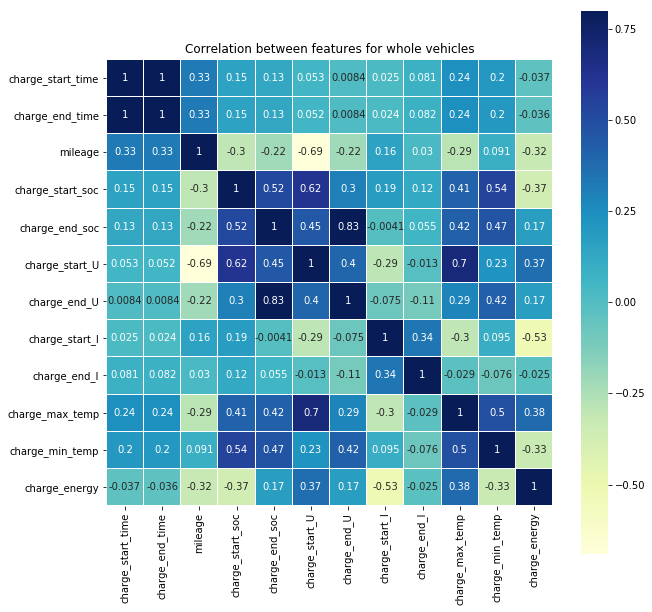

In [3]:
# 总数据相关性勘探
corr=dataset[header[1:]].corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, vmax=0.8, linewidths=0.01,
            square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features for whole vehicles');

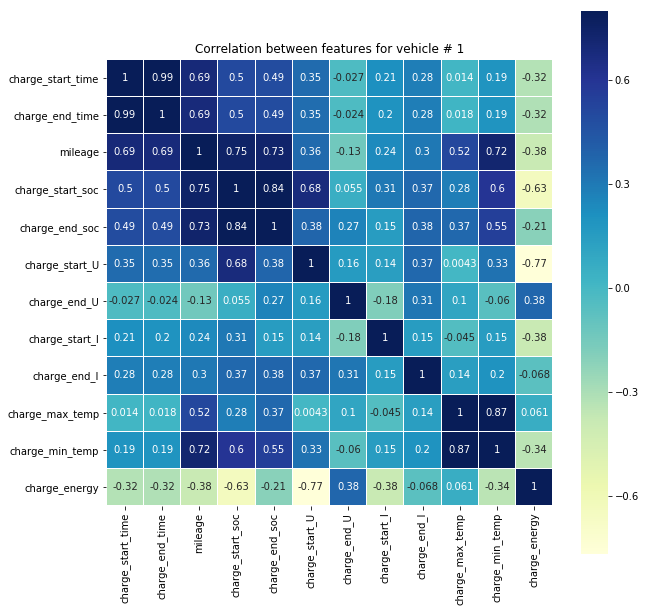

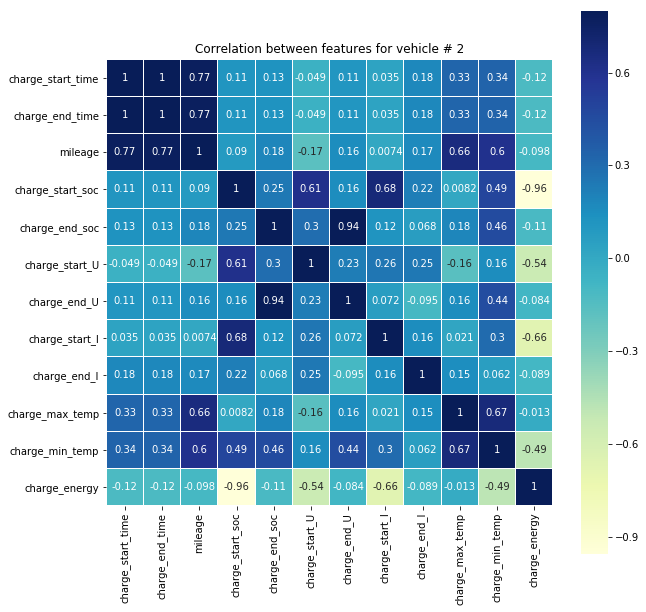

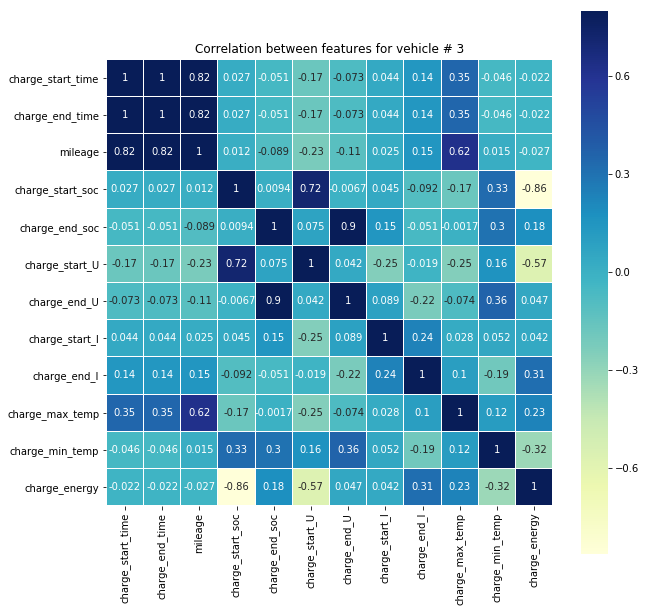

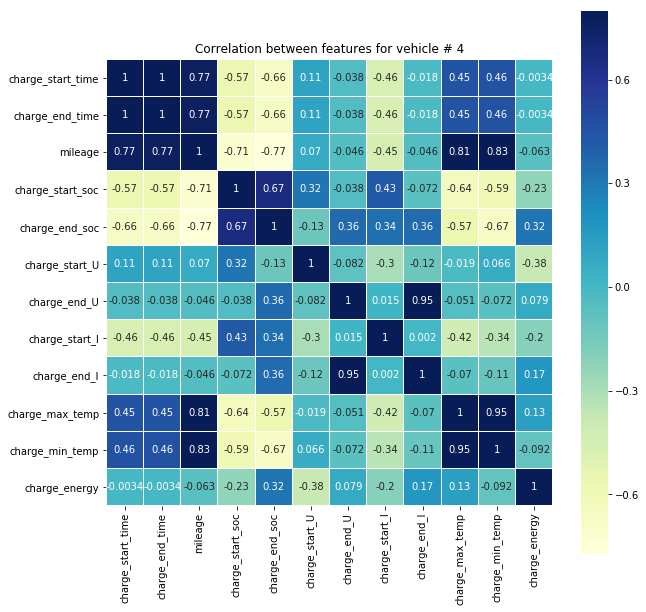

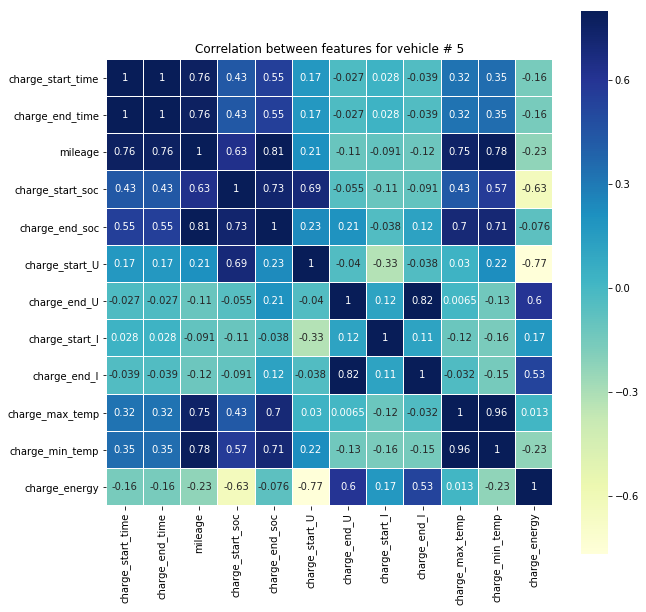

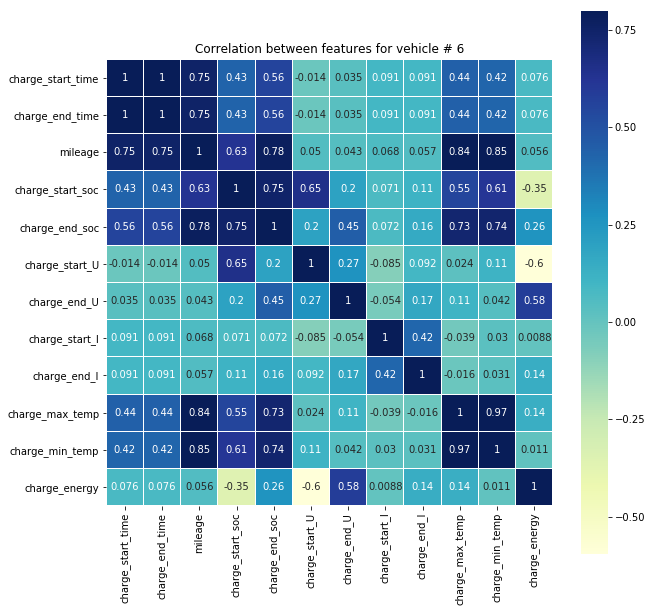

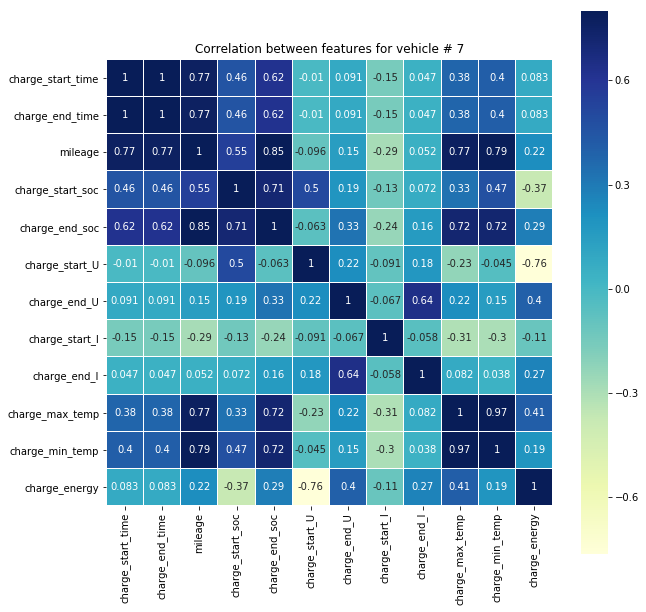

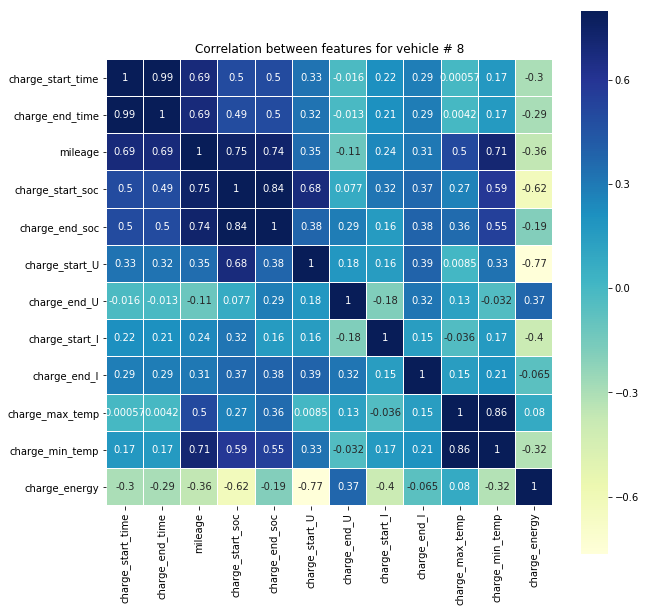

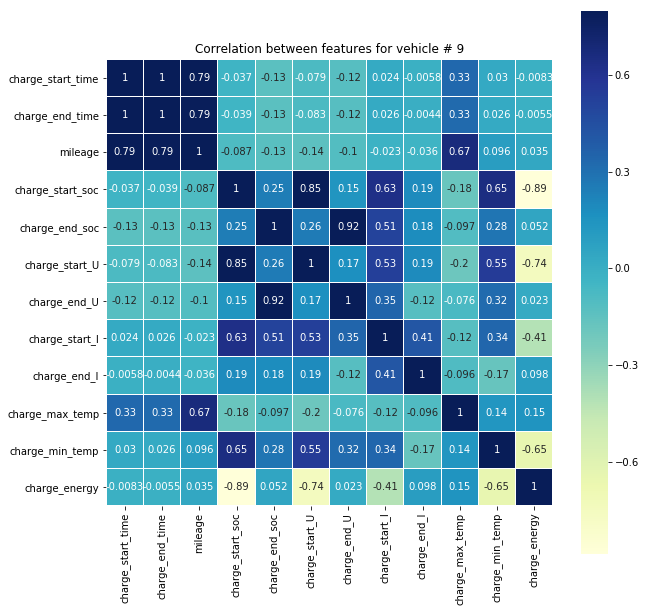

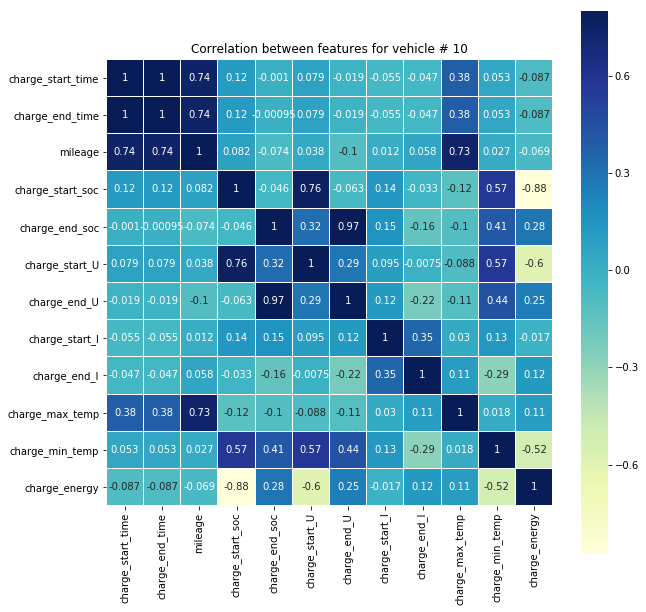

In [4]:
# 对不同车的数据进行相关性分析，会发现更多信息。
for i in range(1, count+1):
    data = dataset[(dataset['vehicle_id']==i)]
    data = data[header[1:]]
    corr=data.corr()
    plt.figure(figsize=(10, 10))
    sns.heatmap(corr, vmax=0.8, linewidths=0.01,
                square=True,annot=True,cmap='YlGnBu',linecolor="white")
    plt.title('Correlation between features for vehicle # %d' % i);

>观察：对于这10辆车，发现对充电能量影响较大的有：charge_start_soc、charge_start_U、charge_min_temp。

### 特征工程。

#### 增加新的特征集——充电时间间隔（charge_duration）与SOC变化值（charge_delta_soc）以及里程变化值（delta_mileage，两次充电间该汽车行驶里程数，对于提供的数据集来说，每辆车第一条记录，距上一次充电间的行驶里程是不确定的。接下来，我们将会用聚类的方法对该值进行填充）；

In [5]:
# 增加充电时间间隔属性
charge_end_time_array = np.array(utils.calVecTimeStamp(dataset['charge_end_time']))
charge_start_time_array = np.array(utils.calVecTimeStamp(dataset['charge_start_time']))
dataset['charge_duration'] = (charge_end_time_array - charge_start_time_array).tolist()

# 增加充电SOC变化量
charge_start_soc_array = np.array(dataset['charge_start_soc'])
charge_end_soc_array = np.array(dataset['charge_end_soc'])
dataset['charge_delta_soc'] = (charge_end_soc_array - charge_start_soc_array).tolist()

# 增加充电前汽车行驶里程数，要分车进行
delta_mileage_list_all = []
for i in range(1, count+1):
    delta_mileage_list_all.append(np.NaN)
    mileage_list = dataset[dataset['vehicle_id']==i]['mileage'].tolist()
    for j in range(1, len(mileage_list)):
        delta_mileage_list_all.append(mileage_list[j] - mileage_list[j-1])
dataset['delta_mileage'] = delta_mileage_list_all

# 重构数据集
header.insert(3, 'charge_duration')
header.insert(5, 'delta_mileage')
header.insert(8, 'charge_delta_soc')

dataset = dataset[header]

# 保存数据
dataset.to_csv("./energy_predict_data/train_data_filter/2_feature_engineering/predict_data_e_train.csv", index=False)

#### 特征工程后的数据集

In [6]:
pd.set_option('precision', 2)
dataset.describe()

,vehicle_id,charge_start_time,charge_end_time,charge_duration,mileage,delta_mileage,charge_start_soc,charge_end_soc,charge_delta_soc,charge_start_U,charge_end_U,charge_start_I,charge_end_I,charge_max_temp,charge_min_temp,charge_energy
count,5860.00,5.86e+03,5.86e+03,5860.00,5860.00,5850.00,5853.00,5817.00,5816.00,5860.00,5860.00,5860.00,5860.00,5860.00,5860.00,5.86e+03
mean,5.17,2.02e+13,2.02e+13,3576.89,108324.26,81.67,48.88,70.32,21.35,460.68,439.73,-44.82,-19.69,29.46,15.67,2.34e+01
std,3.06,3.99e+09,3.99e+09,4511.58,31142.88,202.77,30.08,34.48,31.98,103.54,157.18,55.86,40.51,10.69,13.02,2.44e+01
min,1.00,2.02e+13,2.02e+13,10.00,45631.70,-250.20,0.80,0.00,-100.00,252.00,0.00,-202.00,-400.00,-2.00,-7.00,1.00e-03
25%,2.00,2.02e+13,2.02e+13,730.00,83569.40,14.00,25.00,34.00,0.00,345.20,372.50,-64.50,-16.10,21.00,2.00,3.85e+00
50%,5.00,2.02e+13,2.02e+13,2380.00,106180.00,69.50,42.00,86.00,21.00,533.60,394.70,-21.00,-7.70,31.00,15.00,1.65e+01
75%,8.00,2.02e+13,2.02e+13,4559.25,129317.50,115.00,68.00,100.00,44.00,551.30,565.60,-7.50,-1.00,37.00,27.00,3.26e+01
max,10.00,2.02e+13,2.02e+13,42770.00,184014.00,9703.00,100.00,100.00,88.00,595.30,604.80,-0.10,9.00,52.00,44.00,1.10e+02


#### 查看特征工程前后的相关性的变化并保存文件

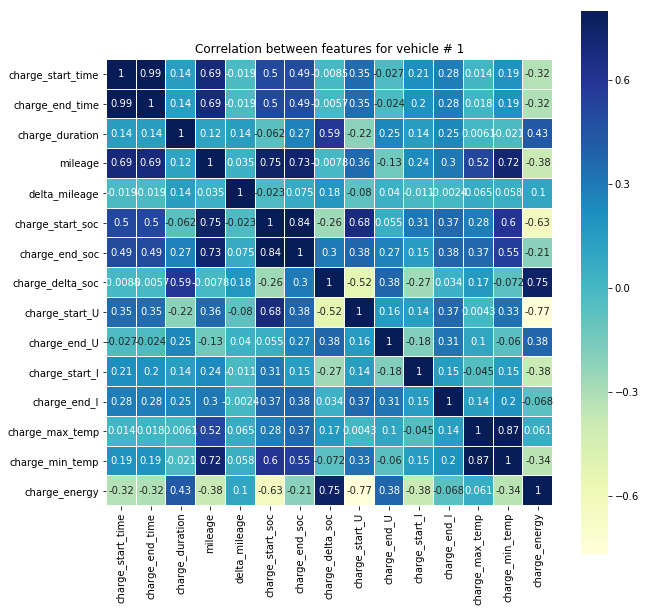

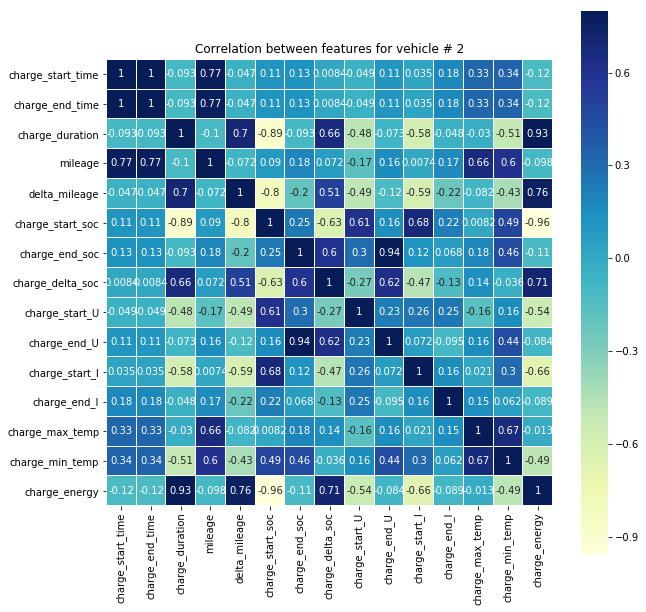

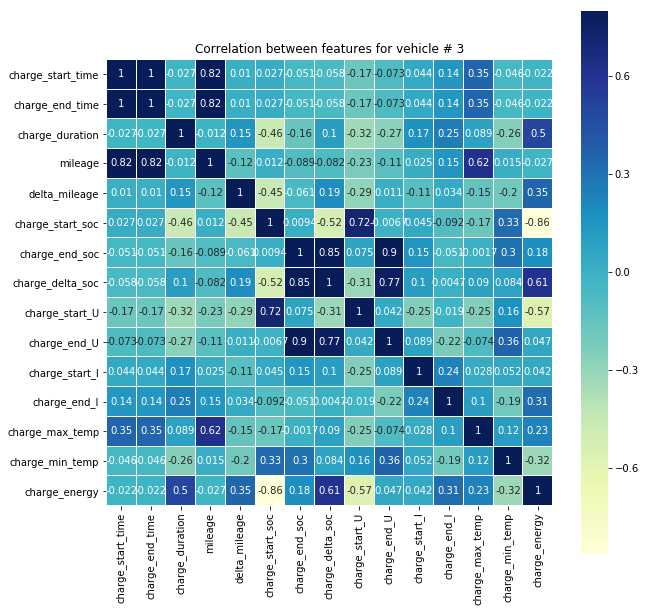

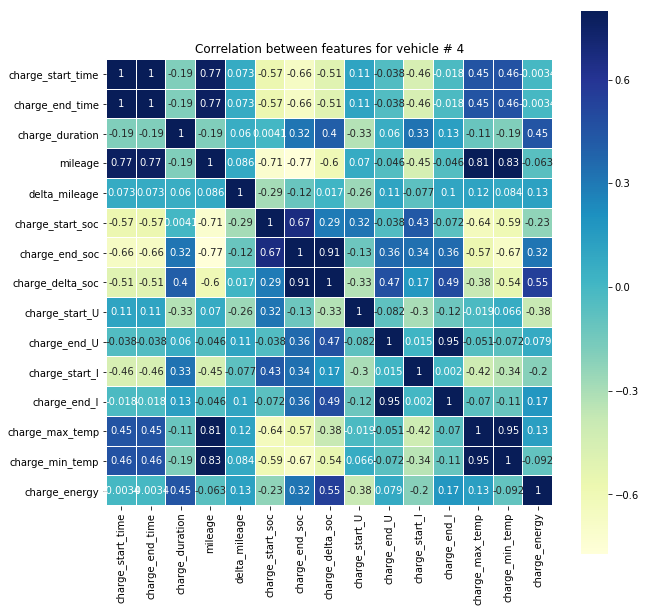

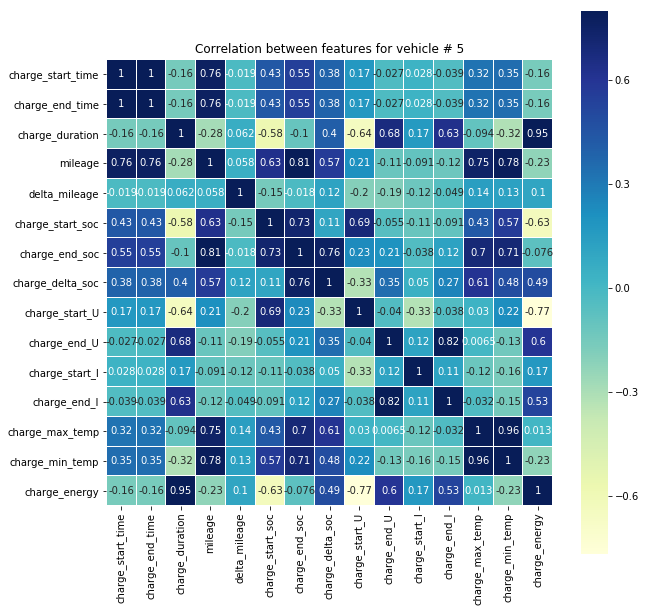

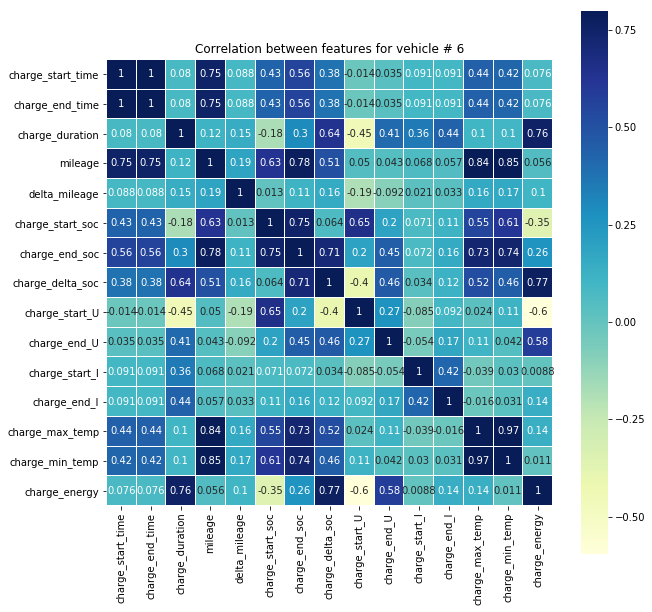

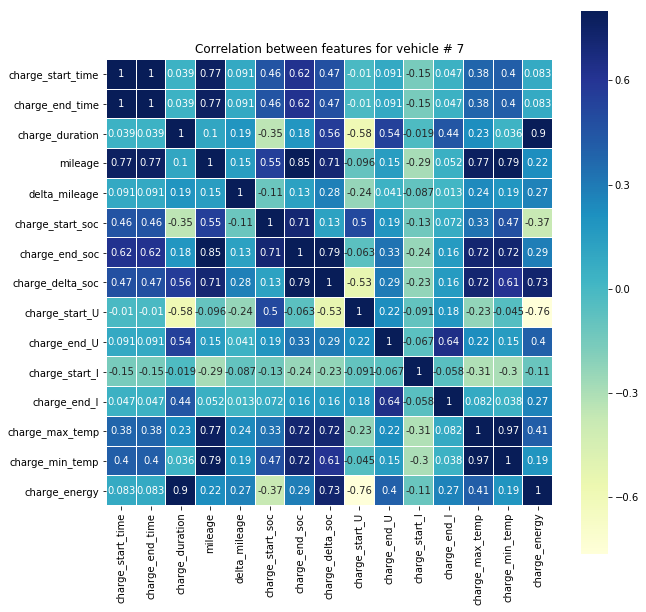

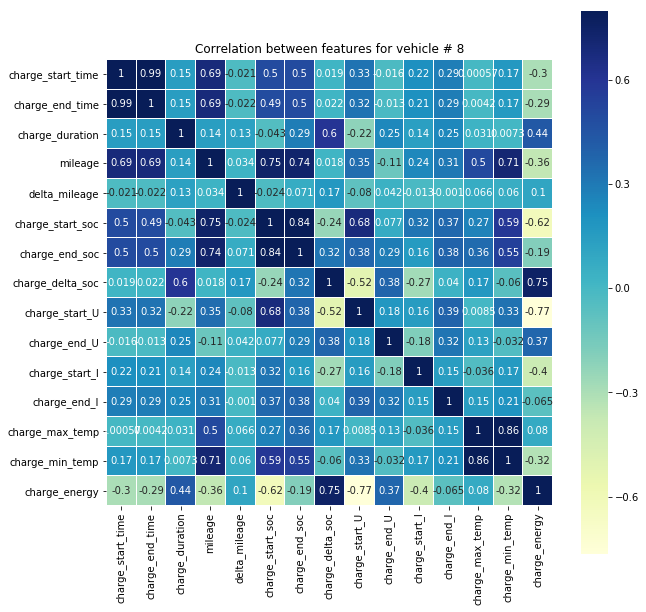

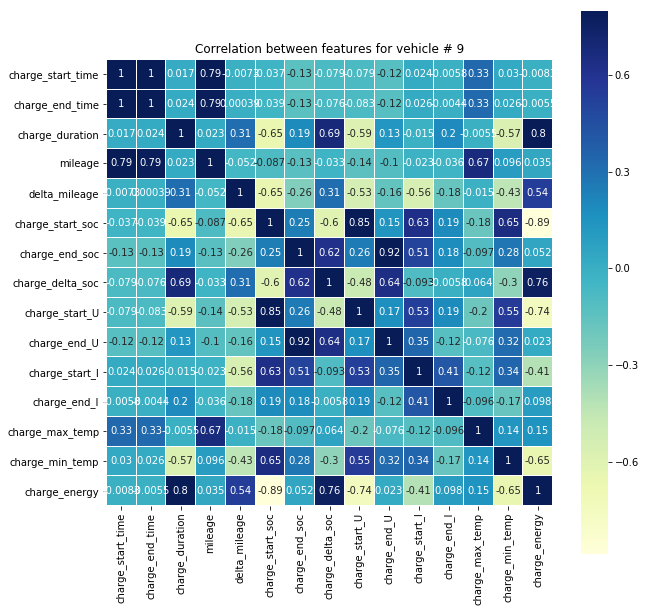

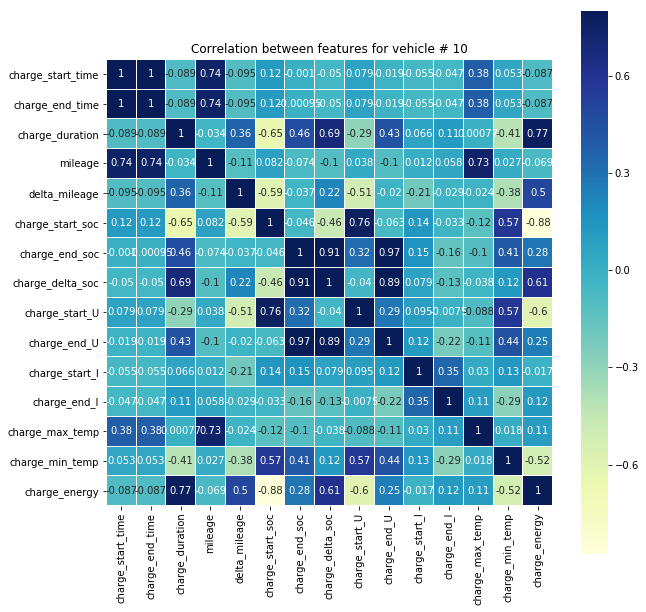

In [7]:
# 对不同车的数据进行相关性分析，会发现更多信息
for i in range(1, count+1):
    data = dataset[(dataset['vehicle_id']==i)]
    temp = data[header[1:]]
    
    # 相关性可视化
    corr=temp.corr()
    plt.figure(figsize=(10, 10))
    sns.heatmap(corr, vmax=0.8, linewidths=0.01,
                square=True,annot=True,cmap='YlGnBu',linecolor="white")
    plt.title('Correlation between features for vehicle # %d' % i);
    
    # 保存data
    data.to_csv("./energy_predict_data/train_data_filter/2_feature_engineering/predict_data_e_train_%d.csv" % i, index=False)

>观察：特征工程后，相关性更加明显，可发现对充电能量影响较大的有：charge_duration、delta_mileage、charge_start_soc、charge_delta_soc、charge_start_U、charge_min_temp。